#### **Library imports**

In [4]:
# Library imports
import pyforest
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
from pprint import pprint
from time import sleep
import time
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from turtle import forward
import torch.nn as nn
import torch.nn.functional as F
import math
import torch
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.utils.data import DataLoader, TensorDataset

import models 
from models import get_accuracy
import inspect

#### **Load dataset**

In [5]:
dataset = 'movielens'
use_gpu = 1

train_edges = np.load('data/' + dataset + '/train_edges.npy')
test_edges = np.load('data/' + dataset + '/test_edges.npy')

user_list_train = train_edges[:, 0]
user_list_test = test_edges[:, 0]
item_list_train = train_edges[:, 1]
item_list_test = test_edges[:, 1]
rating_list_train = train_edges[:, 2].astype('float32')
rating_list_test = test_edges[:, 2].astype('float32')

n_users = max(user_list_train.max(), user_list_test.max()) + 1 
n_items = max(item_list_train.max(), item_list_test.max()) + 1
n_samples_train = len(rating_list_train)
n_samples_test = len(rating_list_test)

print('n_users:', n_users)
print('n_items:', n_items)
print('n_samples_train:', n_samples_train)
print('n_samples_test:', n_samples_test)

if use_gpu == -1:
    device = 'cpu'
else:
    device = torch.device('cuda:{}'.format(str(use_gpu)) if torch.cuda.is_available() else 'cpu')

users = torch.tensor(user_list_train, device = device)
items = torch.tensor(item_list_train, device = device)
ratings = torch.tensor(rating_list_train, device = device, requires_grad = True)

users_test = torch.tensor(user_list_test, device = device)
items_test = torch.tensor(item_list_test, device = device)
ratings_test = torch.tensor(rating_list_test, device = device)

ratings_np = ratings.detach().to('cpu').int().numpy()
ratings_test_np = ratings_test.detach().to('cpu').int().numpy()

n_users: 943
n_items: 1682
n_samples_train: 159619
n_samples_test: 40381


#### **Check available models**

In [6]:
[m[0] for m in inspect.getmembers(models, inspect.isclass) if m[1].__module__ == 'models']

['CF', 'CFD', 'GMF', 'GMFB', 'GMFD', 'MLP', 'NeuMF']

#### **Train CF model**

In [7]:
device

device(type='cuda', index=1)

100%|██████████| 100/100 [00:05<00:00, 17.26it/s]


max meta grad:  0.00022516837634611875
min meta grad:  -inf
Training accuracy:  0.8831467628479004
Training AUC:  0.9546998077563144
Validation accuracy:  0.8224660158157349
Validation AUC:  0.900886888523625
Max validation accuracy:  0.9009098952455719
Max validation AUC:  0.9009098952455719
Execution time: 00h 00m 05s


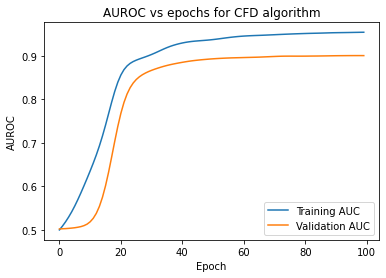

In [8]:
seed = 0
start_time = time.time()
torch.manual_seed(seed)

# architecture
algorithm = 'CFD'
n_factors = 16

# hyperparameters
dropout = 0.3 
lr = 0.1
T = 100

if dropout == None:
    model = getattr(models, algorithm)(n_users, n_items, n_factors).to(device)
else:
    model = getattr(models, algorithm)(n_users, n_items, n_factors, dropout).to(device)
    
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
loss_fn = torch.nn.BCELoss(reduction = 'mean')

train_auc = []
valid_auc = []

for _ in tqdm(range(T)):
    model.eval()
    with torch.no_grad():
        y_hat = model(users, items).detach().to('cpu').numpy()
        y_hat_test = model(users_test, items_test).detach().to('cpu').numpy()
        train_auc.append(roc_auc_score(ratings_np, y_hat))
        valid_auc.append(roc_auc_score(ratings_test_np, y_hat_test))
    
    model.train()
    y_hat = model(users, items)
    loss = loss_fn(y_hat, ratings)
    optimizer.zero_grad()
    loss.backward(retain_graph = True)
    optimizer.step()

model.eval()
loss = loss_fn(y_hat, ratings)
meta_grad = torch.autograd.grad(loss, ratings)[0]
print('max meta grad: ', meta_grad.max().item())
print('min meta grad: ', meta_grad.min().item())

with torch.no_grad():
    y_hat = model(users, items)
    y_hat_test = model(users_test, items_test)
    print('Training accuracy: ', get_accuracy(y_hat, ratings))
    print('Training AUC: ', roc_auc_score(ratings_np, y_hat.detach().to('cpu').numpy()))
    print('Validation accuracy: ', get_accuracy(y_hat_test, ratings_test))
    print('Validation AUC: ', roc_auc_score(ratings_test_np, y_hat_test.detach().to('cpu').numpy()))
    print('Max validation accuracy: ', max(valid_auc))
    print('Max validation AUC: ', max(valid_auc))

# compute execution time
exec_time = int(time.time() - start_time)
exec_time = time.strftime("%Hh %Mm %Ss", time.gmtime(exec_time))
print('Execution time: {}'.format(exec_time))

plt.plot(train_auc, label = 'Training AUC')
plt.plot(valid_auc, label = 'Validation AUC')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('AUROC')
plt.title('AUROC vs epochs for {} algorithm'.format(algorithm))
plt.show()

#### **Explore model's layers**

In [10]:
with torch.no_grad():
    print(model)
    print(model.user_emb)
    print(model.user_emb(torch.tensor(1).to(device)).to('cpu').numpy())

CFD(
  (user_emb): Embedding(943, 16)
  (item_emb): Embedding(1682, 16)
  (drop_u): Dropout(p=0.3, inplace=False)
  (drop_i): Dropout(p=0.3, inplace=False)
)
Embedding(943, 16)
[-0.96943915  0.80677354 -0.0138462   0.31286424  0.05106794 -0.2907922
  1.1062822  -1.6264924   1.3075551  -0.17486116 -0.43694013  0.53625154
 -1.8122196  -0.284137    0.9490774   0.22086936]


#### **T-SNE visualisation of user embeddings**

In [11]:
user_embeddings = []
model.to('cpu')
for u in range(n_users):
    user = torch.tensor(u)
    emb = model.user_emb(user).detach().numpy().tolist()
    user_embeddings.append(emb)

print(len(user_embeddings))
print(len(user_embeddings[0]))

943
16


In [12]:
user_embeddings = np.array(user_embeddings)
print(user_embeddings.shape)
user_embeddings

(943, 16)


array([[ 0.05963557,  0.07603691,  0.86843801, ..., -0.29347864,
        -0.24522734,  0.32479405],
       [-0.96943915,  0.80677354, -0.0138462 , ..., -0.28413701,
         0.94907743,  0.22086936],
       [-1.54250813,  1.89589274,  0.37137538, ...,  0.64379537,
         1.44403529, -0.14466497],
       ...,
       [-0.2739417 ,  0.55487305,  0.02282935, ..., -2.40242743,
         0.52172023,  3.04598379],
       [-1.03312922,  1.51003706, -0.20901324, ...,  0.22331768,
         0.02814743, -0.01702646],
       [-0.98035926,  0.25242826,  0.61856383, ..., -0.7091856 ,
         0.02348971,  0.04859549]])

/home/aravindg1/anaconda3/envs/PyG/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


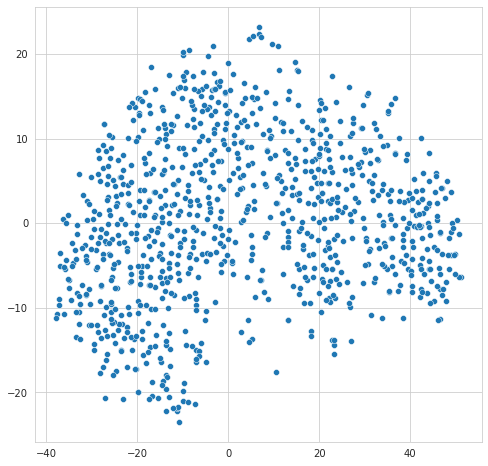

In [79]:
plt.figure(figsize = (8, 8))
user_tsne = TSNE(n_components=2, learning_rate='auto', init='pca', random_state=0).fit_transform(user_embeddings)
sns.set_style('whitegrid')
sns.scatterplot(x = user_tsne[:, 0], y = user_tsne[:, 1])
plt.show()

#### **Select perplexity for T-SNE**

In [ ]:
for perplexity in [1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]:
    plt.figure(figsize = (8, 8))
    user_tsne = TSNE(n_components=2, learning_rate='auto', init='pca', random_state=0, perplexity=perplexity).fit_transform(user_embeddings)
    sns.set_style('whitegrid')
    sns.scatterplot(x = user_tsne[:, 0], y = user_tsne[:, 1]).set_title('perplexity = {}'.format(perplexity))
    plt.savefig('user_clusters_perplexity={}_001.png'.format(perplexity))
    # plt.show()

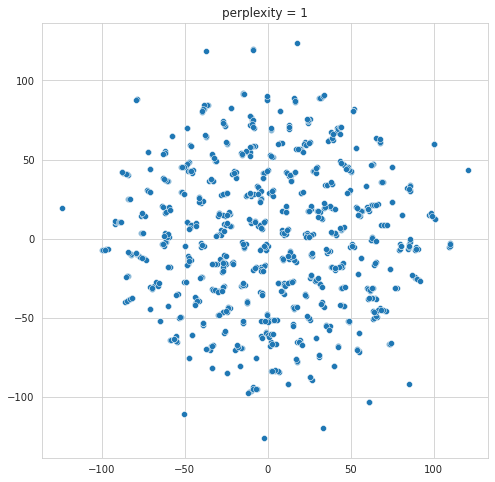

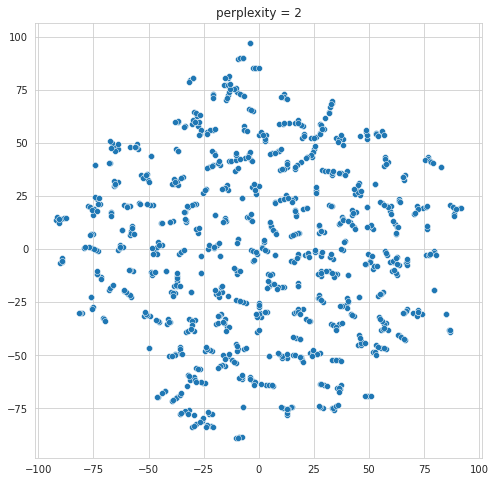

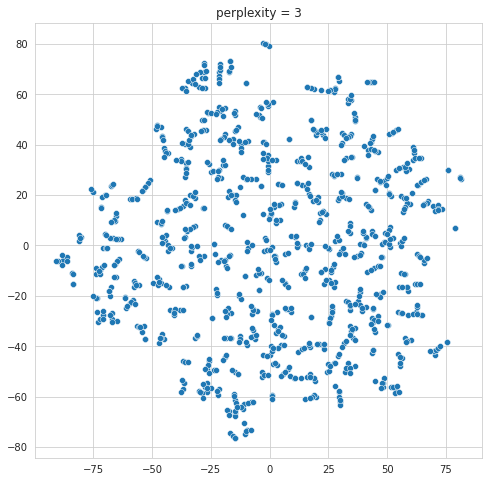

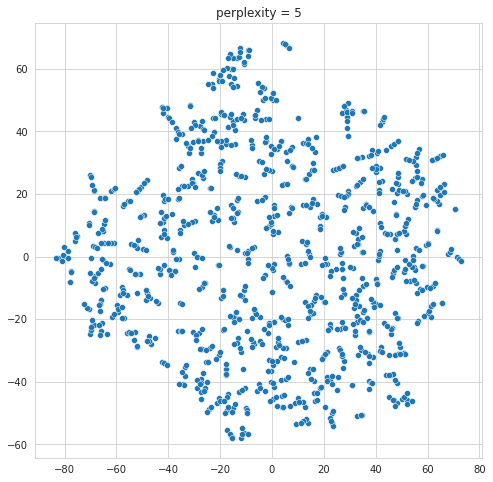

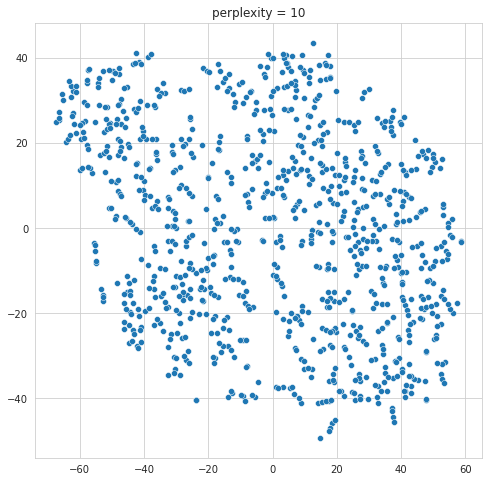

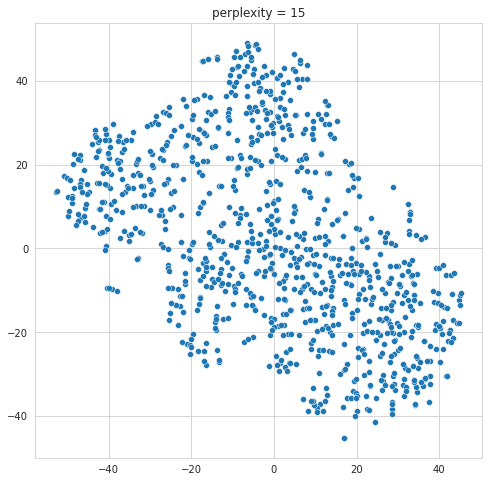

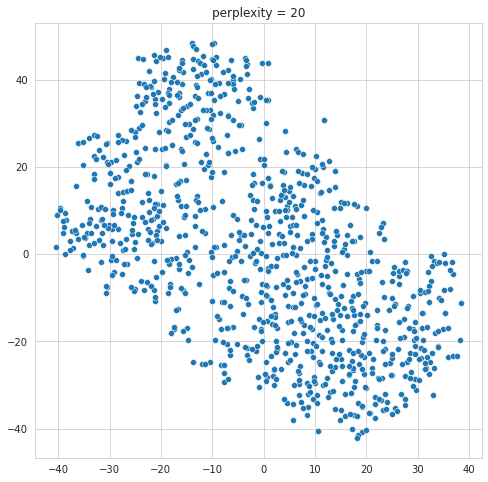

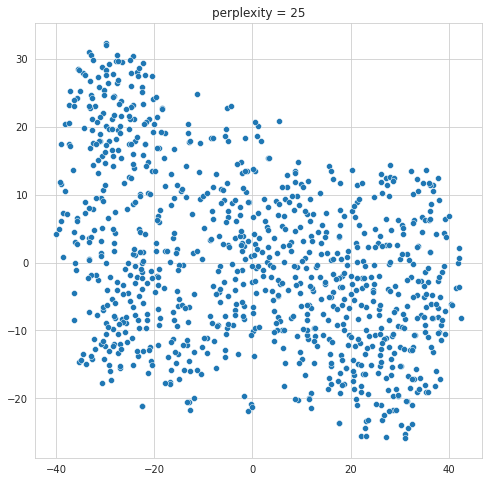

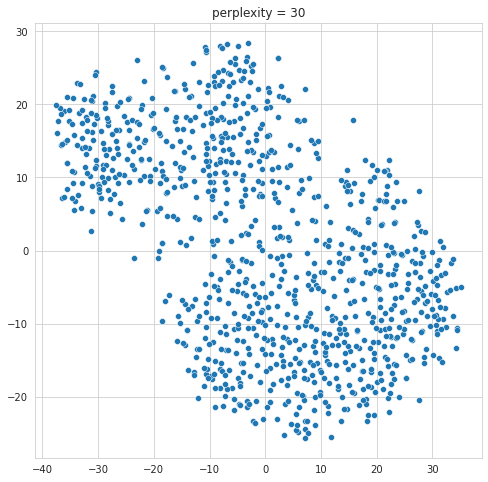

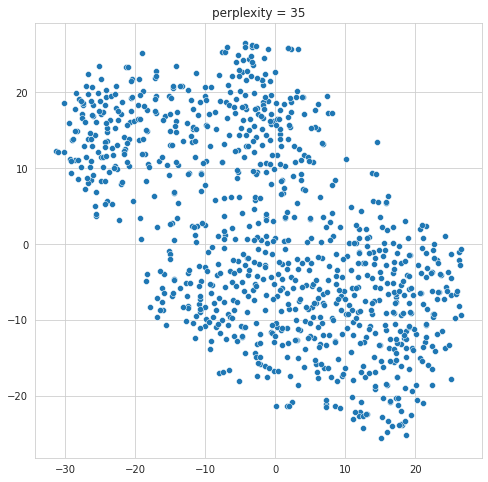

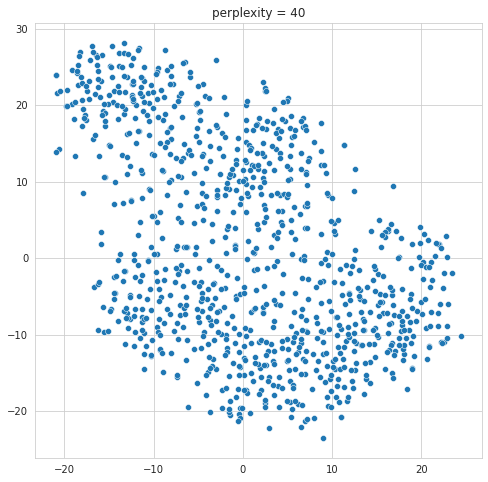

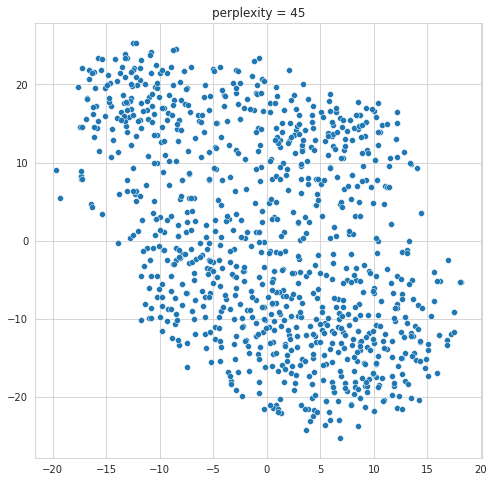

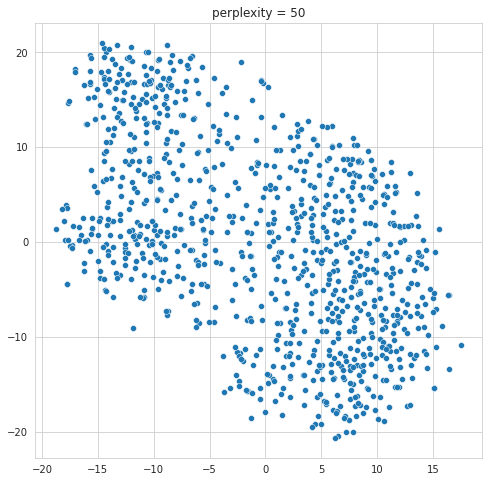

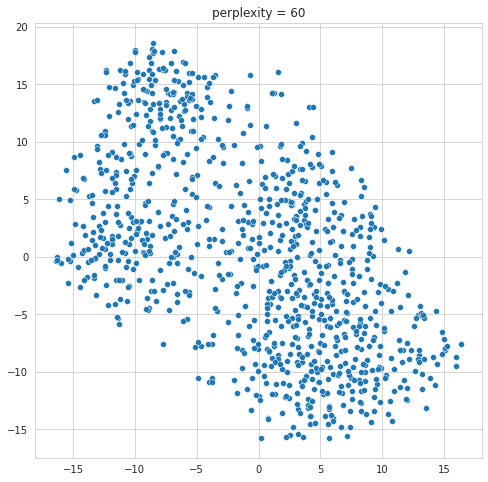

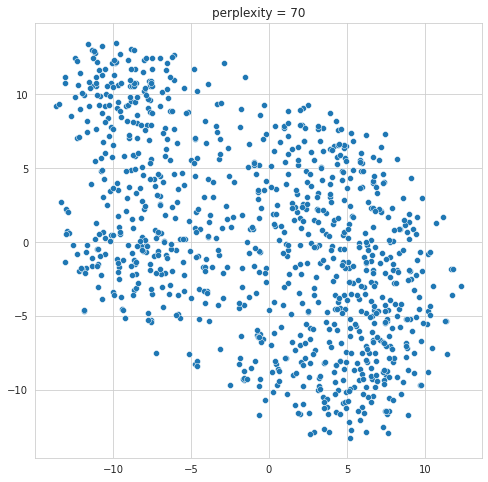

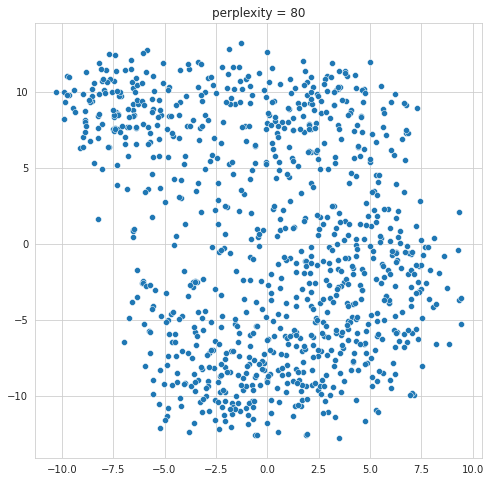

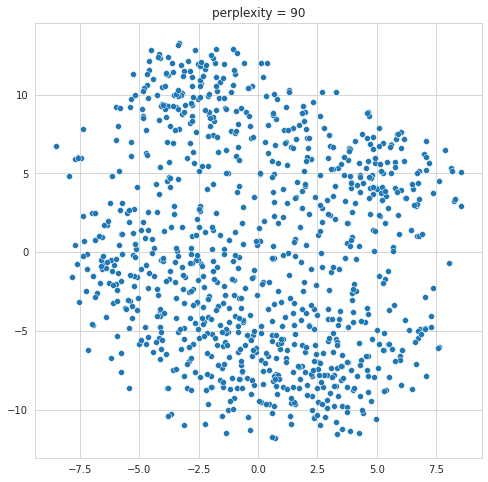

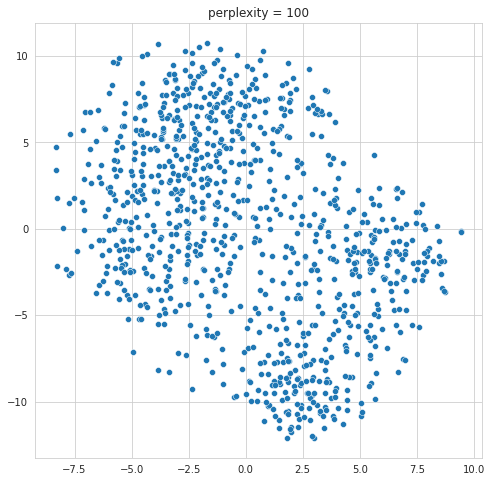

In [87]:
user_tsne = dict()
for perplexity in [1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]:
    plt.figure(figsize = (8, 8))
    user_tsne[perplexity] = TSNE(n_components=2, learning_rate='auto', init='random', random_state=0, perplexity=perplexity).fit_transform(user_embeddings)
    sns.set_style('whitegrid')
    sns.scatterplot(x = user_tsne[perplexity][:, 0], y = user_tsne[perplexity][:, 1]).set_title('perplexity = {}'.format(perplexity))
    plt.show()

#### **K-means on user embeddings**

In [13]:
kmeans = KMeans(n_clusters=50, random_state=0).fit(user_embeddings)
kmeans.labels_
kmeans.cluster_centers_

array([[-2.86114282e-01,  1.82149216e+00,  9.83939366e-01,
        -3.28229131e-01,  2.79819600e-01, -4.82285895e-01,
         6.87151850e-01,  2.90355716e-01,  2.24806745e-01,
         5.95028061e-03, -6.32882963e-01, -4.00134376e-01,
        -5.34799071e-01,  2.75412444e-02,  9.31572552e-02,
         4.64995631e-01],
       [-1.66483266e-01,  1.04680136e+00,  4.73401504e-01,
        -5.92584560e-02, -7.76619998e-02, -3.01659748e-01,
         1.16762337e+00, -1.20821526e+00,  1.38474637e+00,
        -3.97348856e-01, -8.09119674e-01,  4.91290162e-01,
        -1.40719827e+00, -1.19574221e+00,  2.06654362e+00,
        -1.67027675e-02],
       [-5.09793140e-01,  1.90977638e-01,  5.29667696e-01,
        -4.88917702e-01,  4.30906898e-01, -3.66653670e-01,
        -1.74813248e-02,  1.88774842e-01, -4.42755316e-02,
        -1.01571064e+00, -9.92948257e-01, -5.53948078e-01,
        -3.70141715e-01, -5.51079469e-01,  6.47083444e-02,
        -3.72577799e-02],
       [-4.44916636e-01,  7.28406505e

In [15]:
centers = kmeans.cluster_centers_
centers.shape

(50, 16)

In [16]:
user_embeddings.shape

(943, 16)

In [17]:
embeddings = np.concatenate((user_embeddings, centers), axis=0)
print(embeddings.shape)
embeddings

(993, 16)


array([[ 0.05963557,  0.07603691,  0.86843801, ..., -0.29347864,
        -0.24522734,  0.32479405],
       [-0.96943915,  0.80677354, -0.0138462 , ..., -0.28413701,
         0.94907743,  0.22086936],
       [-1.54250813,  1.89589274,  0.37137538, ...,  0.64379537,
         1.44403529, -0.14466497],
       ...,
       [-0.51083856,  0.37199646,  0.27118584, ..., -1.05883697,
         0.16963384,  0.27475556],
       [-0.72120205,  1.79749131,  0.24362323, ...,  0.76104899,
         1.43811327, -0.18744807],
       [-0.49182186,  0.60930234,  0.37360833, ..., -0.28604138,
         1.72513061,  0.05375731]])

In [18]:
marker = np.zeros(993, dtype = np.int8)
marker[943:] = 1
print(marker.shape)

(993,)


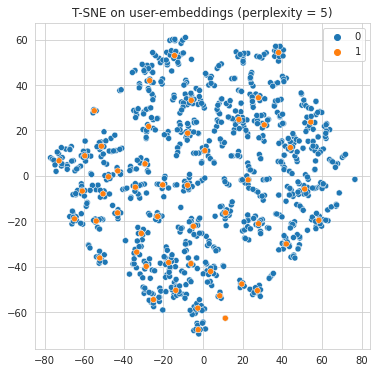

In [24]:
perplexity = 5
tsne = TSNE(n_components=2, learning_rate='auto', init='random', random_state=0, perplexity=perplexity).fit_transform(embeddings)
plt.figure(figsize = (6, 6))
sns.set_style('whitegrid')
sns.scatterplot(x = tsne[:, 0], y = tsne[:, 1], hue = marker).set_title('T-SNE on user-embeddings (perplexity = {})'.format(perplexity))
plt.savefig('user_clusters_kmeans_perplexity={}_002.png'.format(perplexity))
plt.show()

#### **Select t-sne perplexity for k-means**

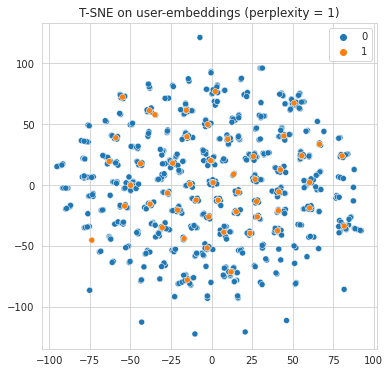

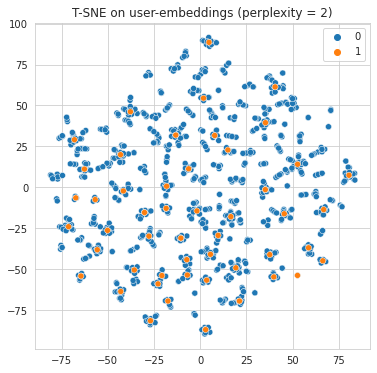

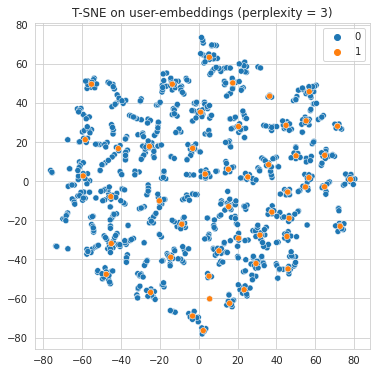

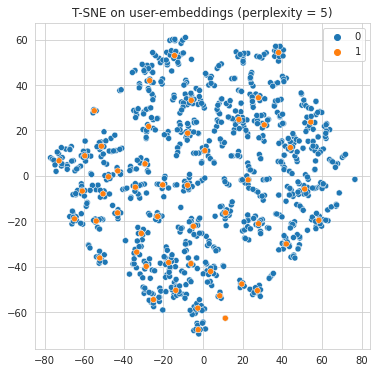

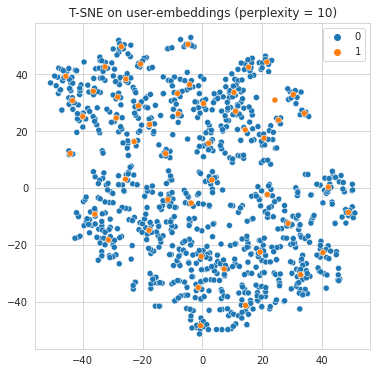

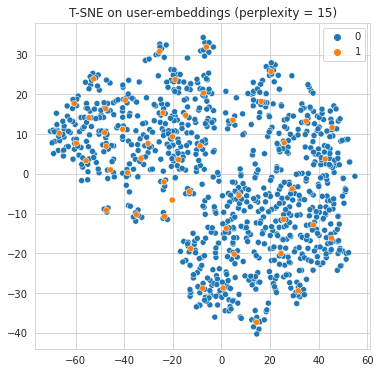

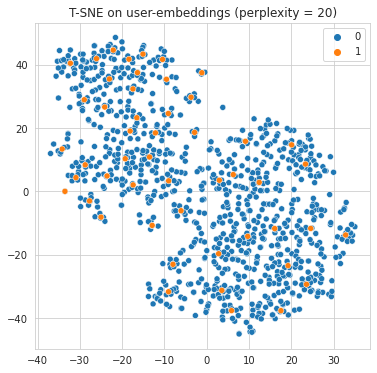

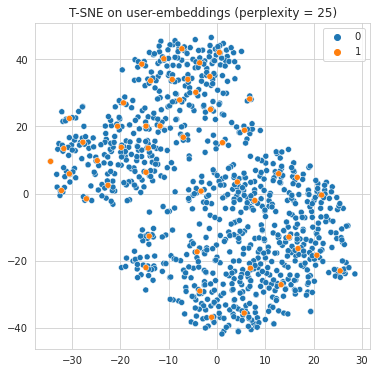

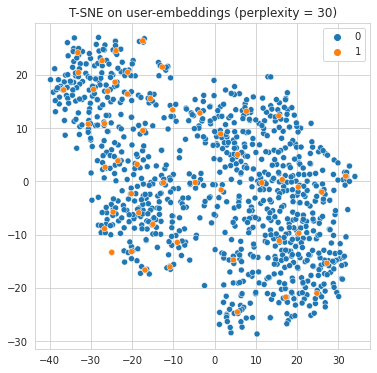

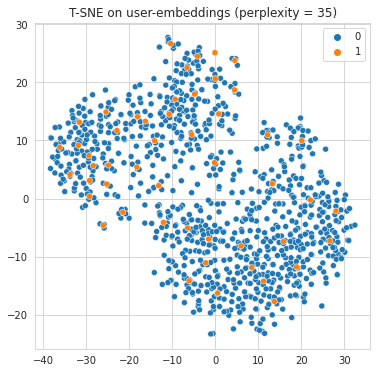

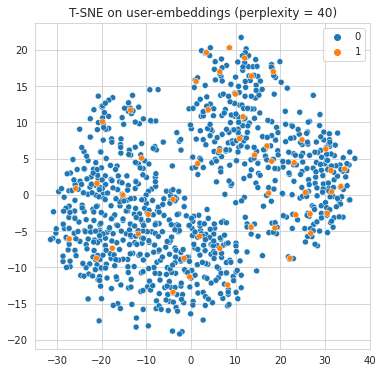

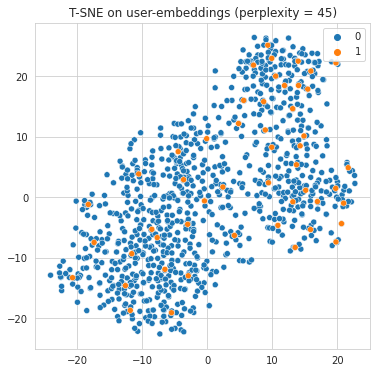

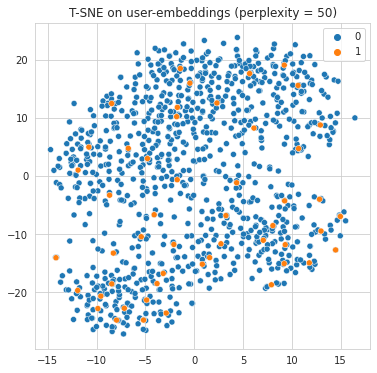

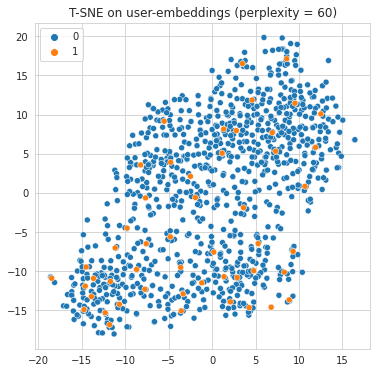

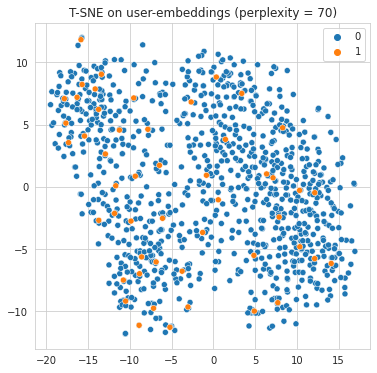

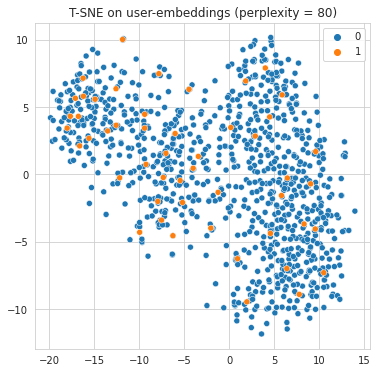

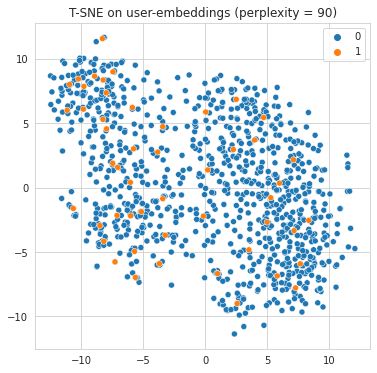

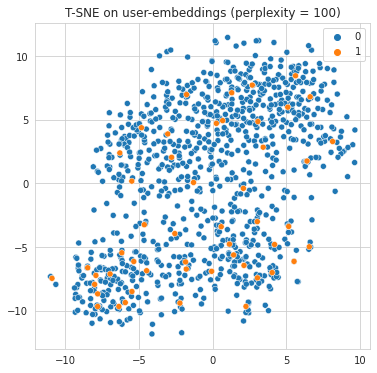

In [26]:
for perplexity in [1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]:
    tsne = TSNE(n_components=2, learning_rate='auto', init='random', random_state=0, perplexity=perplexity).fit_transform(embeddings)
    plt.figure(figsize = (6, 6))
    sns.set_style('whitegrid')
    sns.scatterplot(x = tsne[:, 0], y = tsne[:, 1], hue = marker).set_title('T-SNE on user-embeddings (perplexity = {})'.format(perplexity))
    plt.savefig('user_clusters_kmeans_perplexity={}_003.png'.format(perplexity))
    plt.show()